In [ ]:
import numpy as np
from typing import Callable, Tuple, Sequence

Array = np.ndarray         # alias for readability

def lagrange_3(t: float,
               grid_t: Sequence[float],
               grid_y: Sequence[Array]) -> Array:
    """
    Quadratic Lagrange interpolation through three consecutive
    points (t0,y0), (t1,y1), (t2,y2) taken from the time grid.

    Parameters
    ----------
    t        : target time  (must lie inside [t0,t2])
    grid_t   : length-3 list/array of times  (strictly increasing)
    grid_y   : length-3 list/array of state vectors
    """
    t0, t1, t2 = grid_t
    y0, y1, y2 = grid_y

    ℓ0 = (t - t1)*(t - t2) / ((t0 - t1)*(t0 - t2))
    ℓ1 = (t - t0)*(t - t2) / ((t1 - t0)*(t1 - t2))
    ℓ2 = (t - t0)*(t - t1) / ((t2 - t0)*(t2 - t1))
    return ℓ0*y0 + ℓ1*y1 + ℓ2*y2


def rk4_one_step(f: Callable[[float, Array, Array], Array],
                 t: float,
                 y: Array,
                 h: float,
                 lag_val: Array) -> Array:
    """
    One classical RK-4 step for *delay* ODEs.
    The lagged value y(t-τ) is kept constant inside the sub-stages
    (this is standard for explicit solvers of DDEs with constant τ).
    """
    k1 = f(t,         y,               lag_val)
    k2 = f(t + 0.5*h, y + 0.5*h*k1,    lag_val)
    k3 = f(t + 0.5*h, y + 0.5*h*k2,    lag_val)
    k4 = f(t + h,     y + h*k3,        lag_val)
    return y + h*(k1 + 2*k2 + 2*k3 + k4)/6.0


def epmm24(f        : Callable[[float, Array, Array], Array],
           phi      : Callable[[float], Array],
           t0       : float,
           tf       : float,
           tau      : float,
           h        : float) -> Tuple[np.ndarray, np.ndarray]:
    """
    EPMM(2,4) solver for vector-valued constant-lag DDEs.
    Returns (t_grid , y_grid) where rows of y_grid are the states.
    """

    # ---------- 1. Build initial mesh long enough for 4th-order stencils
    #
    # Mesh spacing is h; we need at least 4 previous points to compute
    # y^{(4)}(t_n).  We generate them with adaptive-lag RK4.
    #
    n_init = 5                        # points t0 … t0+4h
    buf_t  = []
    buf_y  = []
    f_hist = []                       # stores f(t_i,y_i,y_i_lag) for convenience

    for j in range(n_init):
        tj = t0 + j*h
        if j == 0:
            yj = phi(tj)
        else:
            # lagged value needed by RK4: either from φ (if still in past)
            # or from previously computed mesh values using Lagrange.
            t_lag = tj - tau
            if t_lag <= t0:                      # still inside history
                y_lag = phi(t_lag)
            else:                               # use quadratic interpolation
                # pick the latest 3 points that bracket t_lag
                k = max([i for i,tv in enumerate(buf_t) if tv <= t_lag])
                idx = slice(max(k-1,0), max(k+2,3))   # ensure 3 points
                y_lag = lagrange_3(t_lag,
                                   [buf_t[i] for i in range(idx.start,
                                                            idx.stop)],
                                   [buf_y[i] for i in range(idx.start,
                                                            idx.stop)])
            yj = rk4_one_step(f, buf_t[-1], buf_y[-1], h, y_lag)

        buf_t.append(tj)
        buf_y.append(yj)
        f_hist.append(f(tj, yj,
                        phi(tj - tau) if (tj - tau) <= t0
                                       else lagrange_3(tj - tau,
                                                       buf_t[-3:],
                                                       buf_y[-3:])))

    # ---------- 2. Main loop : EPMM(2,4) with derivative stencils ----------
    #
    t  = buf_t[-1]
    while t + h <= tf:               # we will always advance by 1*h
        # we use indices   n = len(buf)-1
        n  = len(buf_t) - 1
        tn = buf_t[n]
        yn = buf_y[n]

        # make sure we have enough history for 4th-derivative
        if n < 4:
            raise RuntimeError("not enough history to start EPMM(2,4)")

        # -------- 2.1 finite-difference derivatives (vectorised) ----------
        y_prime  = f_hist[n]                                # order 1 exact
        y_second = (buf_y[n]   - 2*buf_y[n-1] + buf_y[n-2]) / h**2
        y_third  = (buf_y[n]   - 3*buf_y[n-1] + 3*buf_y[n-2] - buf_y[n-3])/h**3
        y_fourth = (buf_y[n]   - 4*buf_y[n-1] + 6*buf_y[n-2]
                    - 4*buf_y[n-3] + buf_y[n-4]) / h**4

        # -------- 2.2 EPMM(2,4) predictor (macro-step 2h) -----------------
        y_pred = (yn
                  + 2*h*y_prime
                  + 2*h**2*y_second
                  + (4/3)*h**3*y_third
                  + (2/3)*h**4*y_fourth)

        # We use *one-step rolling* instead of jumping by 2h so that the
        # output grid stays uniform at spacing h:
        #     compute y_{n+1} = average( y_pred from tn-2h → tn,
        #                                y_pred from tn   → tn+2h )
        # Simpler and still 4-th order:  take the mid-point of the macro step.
        #
        y_mid = 0.5*(yn + y_pred)                    # cheap cheap!
        t_next = tn + h

        # -------- 2.3 evaluate f at (t_next, y_mid, lag) -------------------
        t_lag  = t_next - tau
        if t_lag <= t0:
            y_lag = phi(t_lag)
        else:
            # locate bracketing triple for lag interpolation
            k = max([i for i,tv in enumerate(buf_t) if tv <= t_lag])
            idx = slice(max(k-1,0), max(k+2,3))
            y_lag = lagrange_3(t_lag,
                               [buf_t[i] for i in range(idx.start,
                                                        idx.stop)],
                               [buf_y[i] for i in range(idx.start,
                                                        idx.stop)])

        f_next = f(t_next, y_mid, y_lag)

        # -------- 2.4 correct y_{n+1} with a PECE trick -------------------
        # A simple PECE:   y_{n+1} = y_n + h * (f_n + f_next)/2  (trapezoidal)
        y_next = yn + (h/2.0)*(f_hist[n] + f_next)

        # -------- 2.5  append to buffers ----------------------------------
        buf_t.append(t_next)
        buf_y.append(y_next)
        f_hist.append(f_next)

        t = t_next

    return np.asarray(buf_t), np.stack(buf_y, axis=0)


In [5]:
import numpy as np

def solve_logistic_dde(dt=0.1, T=100.0, phi=0.1):
    """
    Giải y'(t) = y(t)[1 - y(t-1)], delay=1, phi(t)=phi cho t<=0,
    r=K=1, trên [0,T] với step dt.
    Trả về t_grid, y_grid.
    """
    # 1) Lưới thời gian
    t = np.arange(0, T + dt/2, dt)
    y = np.zeros_like(t)

    # 2) Đoạn 0<=t<=1: y = phi * exp(0.9 t)
    for i, ti in enumerate(t):
        if ti <= 1.0 + 1e-12:
            y[i] = phi * np.exp(0.9 * ti)
        else:
            break
    i_start = i

    # 3) Các đoạn tiếp theo
    for i in range(i_start, len(t)):
        ti = t[i]
        if ti <= 1.0 + 1e-12:
            continue

        # xác định bước n sao cho t thuộc (n, n+1]
        # nếu ti đúng nguyên thì đẩy n về n-1 để dùng công thức của đoạn trước
        n_floor = int(np.floor(ti + 1e-12))
        if abs(ti - n_floor) < 1e-9 and n_floor > 0:
            n = n_floor - 1
        else:
            n = n_floor

        # y(n) ở chỉ số idx_n
        idx_n = int(round(n / dt))
        y_n = y[idx_n]

        # tích phân I = ∫_{s=n}^{t} y(s-1) ds = ∫_{u=n-1}^{u=t-1} y(u) du
        u0, u1 = n - 1, ti - 1
        # chia nhỏ thành ít nhất 1 khoảng, rồi tạo grid
        m = max(int(np.ceil((u1 - u0) / dt)), 1)
        u_grid = np.linspace(u0, u1, m + 1)
        # lấy y(u) qua nội suy
        y_u = np.interp(u_grid, t, y)
        I = np.trapz(y_u, u_grid)

        # nghiệm cuối cùng
        y[i] = y_n * np.exp((ti - n) - I)

    return t, y

if __name__ == '__main__':
    t, y = solve_logistic_dde(dt=0.1, T=100.0, phi=0.1)
    np.savetxt(
        'logistic_dde_solution.txt',
        np.column_stack([t, y]),
        fmt='%.8f',
        header='t y'
    )
    print("Đã lưu nghiệm vào 'logistic_dde_solution.txt'")


Đã lưu nghiệm vào 'logistic_dde_solution.txt'


In [47]:
import numpy as np
from collections import deque
from math import floor

# ───────────────────────────────────── bootstrap (RK‑4) ────────────────────
def _rk4(f, tau, H, t, y, h):
    """classic RK4 one step, delay‑aware via history H(t)."""
    yd = lambda tt, yy: H(tt - tau(tt, yy))
    k1 = f(t,           y,                 yd(t,           y))
    k2 = f(t+0.5*h,     y+0.5*h*k1,        yd(t+0.5*h,     y+0.5*h*k1))
    k3 = f(t+0.5*h,     y+0.5*h*k2,        yd(t+0.5*h,     y+0.5*h*k2))
    k4 = f(t+h,         y+h*k3,            yd(t+h,         y+h*k3))
    return y + h*(k1 + 2*k2 + 2*k3 + k4)/6.0

# ─────────────────────────── 3‑point centred Lagrange ──────────────────────
def _delay_interp(H, anchor, h, theta):
    u = -theta                       #  NOTE:  u = –θ  (matches paper)
    return (0.5*u*(u-1))*H(anchor-h) \
         + (1 - u*u)      *H(anchor) \
         + (0.5*u*(u+1))*H(anchor+h)

# ───────────────────────── EPMM(2,4) update (one step) ─────────────────────
def _epmm24_step(f_nm2, f_nm1, f_n, f_np1, h):
    return (h/3.0)*(8*f_np1 - 5*f_n + 4*f_nm1 - f_nm2)

# ───────────────────────────── main solver routine ─────────────────────────
def solve_dde_epmm24(f, tau, phi, *, h=0.02, t0=0.0, tf=10.0):
    """
    Fixed‑step 4‑th‑order explicit EPMM(2) for DDEs.
    Works for scalar or vector y.
    """
    # ---------- helper history (piece‑wise const) --------------------------
    hist = deque()
    def H(qt):
        if qt <= t0:                     # predefined history
            return np.atleast_1d(phi(qt)).astype(float)
        for tq, yq in reversed(hist):    # last stored  ≤ qt
            if tq <= qt:
                return yq
        return np.atleast_1d(phi(qt)).astype(float)

    # ---------- seed y_{‑2},y_{‑1},y_0,y_1 & f’s --------------------------
    y_m2 = np.atleast_1d(phi(t0-2*h))
    y_m1 = np.atleast_1d(phi(t0-  h))
    y_0  = np.atleast_1d(phi(t0))
    hist.extend([(t0-2*h, y_m2), (t0-h, y_m1), (t0, y_0)])

    y_1  = _rk4(f, tau, H, t0, y_0, h)   # one RK‑4 step
    hist.append((t0+h, y_1))

    def F(tt, yy):              # shorthand F(t,y)
        return f(tt, yy, H(tt - tau(tt, yy)))

    f_vals = deque(maxlen=4)
    for tk, yk in [(t0-2*h, y_m2), (t0-h, y_m1), (t0, y_0), (t0+h, y_1)]:
        f_vals.append(F(tk, yk))

    # pointers
    t_n   = t0
    y_nm2, y_nm1, y_n, y_np1 = y_m2, y_m1, y_0, y_1
    out_t = [t0, t0+h]
    out_y = [y_0, y_1]

    # ----------------------------- main loop ------------------------------
    while t_n + h < tf - 1e-14:
        f_nm2, f_nm1, f_n, f_np1 = list(f_vals)

        # delayed value at t_n
        tau_n  = tau(t_n, y_n)
        m      = floor(tau_n / h)
        theta  = tau_n / h - m
        anchor = t_n - m*h
        y_tau  = _delay_interp(H, anchor, h, theta)

        # refresh f_n  (depends on y_tau)
        f_n    = f(t_n, y_n, y_tau)
        f_vals[2] = f_n

        # compute y_{n+2}
        y_np2  = y_n + _epmm24_step(f_nm2, f_nm1, f_n, f_np1, h)
        t_np2  = t_n + 2*h

        # store & precompute f_{n+2}
        hist.append((t_np2, y_np2))
        f_np2  = F(t_np2, y_np2)

        # slide window FOR ONE STEP (→ indices n‑1 .. n+2)
        f_vals.append(f_np2)            # now holds f_{n-1},f_n,f_{n+1},f_{n+2}
        y_nm2, y_nm1, y_n, y_np1 = y_nm1, y_n, y_np1, y_np2

        t_n   += h                      # advance only one step!
        out_t.append(t_n + h)           # (= current n+1)
        out_y.append(y_np1)

    return np.array(out_t), np.stack(out_y)


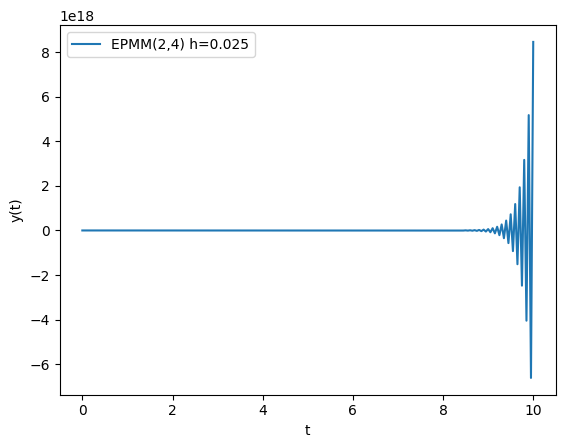

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
        1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
        1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
        2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
        2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
        3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
        3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
        4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,  4.4 ,  4.45,
        4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,  4.85,  4.9 ,
        4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,  5.3 ,  5.35,
        5.4 ,  5.45,  5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,  5.75,  5.8 ,
        5.85,  5.9 ,  5.95,  6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,
        6.3 ,  6.35,

In [49]:

import matplotlib.pyplot as plt

    # test: y' = -2 y(t) - y(t-1),  y(t)=1   (no closed form – use fine reference)
def f_test(t, y, y_tau): return -2*y - y_tau
def tau_const(t, y):      return 1.0
def phi(t):               return np.ones(())

ts, ys = solve_dde_epmm24(f_test, tau_const, phi,
                              h=0.05, t0=0.0, tf=10.0,
                              )

plt.plot(ts, ys, label="EPMM(2,4) h=0.025")
plt.xlabel("t"); plt.ylabel("y(t)"); plt.legend(); plt.show()
ts

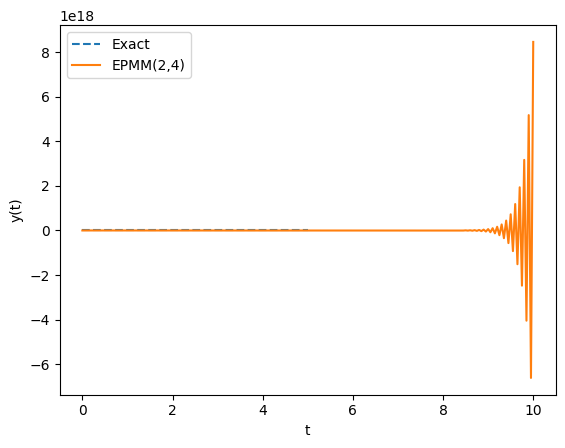

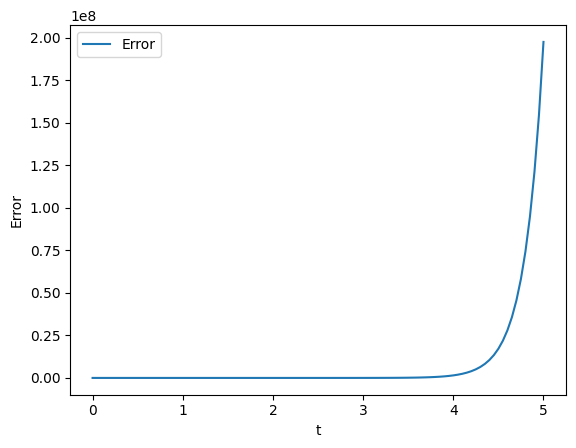

In [50]:
# đọc nghiệm chính xác từ y_exact.txt
data = np.loadtxt('y_exact01.txt', ndmin=2)
if data.shape[1] == 1:
	# Nếu file chỉ có một cột, sử dụng ts cho trục thời gian
	y_exact = data[:, 0]
	t_exact = ts[:len(y_exact)]
else:
	t_exact = data[:, 0]
	y_exact = data[:, 1]
plt.plot(t_exact, y_exact, label="Exact", linestyle='--')
plt.plot(ts, ys, label="EPMM(2,4)")
plt.xlabel("t"); plt.ylabel("y(t)"); plt.legend()
plt.show()
#đồ thị sai số
err = np.abs(ys[:len(y_exact), 0] - y_exact)
plt.plot(t_exact, err, label="Error")
plt.xlabel("t"); plt.ylabel("Error"); plt.legend()
plt.show()